## 对数据进行分析

PDF version does not support the Chinese. So, if you can't open the .ipynb file, please see my [Github](https://github.com/YizhuoLi/NetCloudAnalysis).

### 2.1 词图云

In [1]:
import pandas as pd
dzq_comment_df = pd.read_csv('dzq_comment_sample.tsv',sep='\t')
len(dzq_comment_df)

1330827

In [2]:
# remove duplicate
dzq_comment_df = dzq_comment_df.drop_duplicates()
len(dzq_comment_df)

50018

可以看到重复评论的比例比较高，因为是通过API抓取，应该不是代码出现重复抓取的问题，可能是有着大量的水军的问题。

In [3]:
dzq_comment_list = dzq_comment_df['content'].tolist()
dzq_comment_list[:5]

['如果我没有后顾之忧，父母都身体健康，我应该会跟你走的吧',
 '不回家',
 '乎乎',
 '我没想到为了琳我能疯狂到',
 '第一遍，没感觉\n第二遍，嗯⊙∀⊙！\n第三遍，真香[流泪]']

In [4]:
def load_stopwords():
    '''
    加载停用词
    '''
#     stopwords_path = Constants.STOPWORDS_PATH
    with open('百度停用词表.txt',"r",encoding = "utf-8") as f:
        stopwords = f.readlines()
    stopwords = [word.strip() for word in stopwords]
    return set(stopwords)

In [5]:
import jieba

def cut_text(text):
    '''
    基本的jieba 分词
    :param text: 原始字符串
    :return:
    '''
    return jieba.cut(text)

In [6]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import imageio

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def draw_singer_comments_wordcloud(comment_list):
    '''
    产生歌手评论的词云图像,全部使用默认参数
    :return:
    '''
    if len(comment_list) == 0:
        return 'comment_list error'
    comments_conent = "".join([str(comment) for comment in comment_list])
    d = os.getcwd()
    
    # 设置停用词
    stopwords = load_stopwords()
    
    # Read the whole text.
    wordcloud_text = " ".join([word for word in cut_text(comments_conent) if word not in stopwords])

    # read the mask / color image taken from
    # http://jirkavinse.deviantart.com/art/quot-Real-Life-quot-Alice-282261010
#     alice_coloring = np.array(Image.open("alice_color.png"))
    mask = imageio.imread('alice_color.png')

    # 你可以通过 mask 参数 来设置词云形状
    wc = WordCloud(font_path="simsun.ttc",
                   background_color="white", max_words=2000, mask=mask,
                   stopwords=stopwords, max_font_size=40, random_state=42)
    # generate word cloud
    wc.generate(wordcloud_text)

    # create coloring from image
#     image_colors = ImageColorGenerator(alice_coloring)

    # show
    # 在只设置mask的情况下,你将会得到一个拥有图片形状的词云
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.figure(figsize=(430,370))
    # recolor wordcloud and show
    # we could also give color_func=image_colors directly in the constructor
    # 我们还可以直接在构造函数中直接给颜色
    # 通过这种方式词云将会按照给定的图片颜色布局生成字体颜色策略
#     plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
#     plt.axis("off")
#     plt.figure(figsize=(430,370))
#     plt.imshow(alice_coloring, cmap=plt.cm.gray, interpolation="bilinear")
#     plt.axis("off")
#     plt.show()
    wc.to_file('ciyun.png')

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/lj/4wr4337s4_76_jy8b20q75dr0000gn/T/jieba.cache
Loading model cost 0.639 seconds.
Prefix dict has been built succesfully.


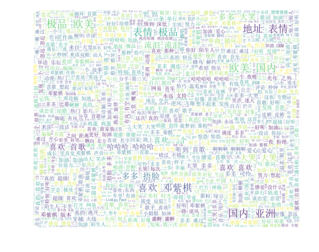

<Figure size 30960x26640 with 0 Axes>

In [7]:
draw_singer_comments_wordcloud(dzq_comment_list)

不知道为什么没办法显示形状，感觉应该是背景图片的问题，但试了几个都不行。

### 用户画像

想做的包括：
1. 粉丝男女比例
2. 粉丝年龄分布
3. 粉丝关注人数，被关注数分布
4. 粉丝听歌数量分布
5. 水军比例

没法做的：  
用户地理位置分布，因为这里的数据抓错了，原因是在抓省份代号的时候，正则表达式多写了一个‘？’。  
现在改动起来比较麻烦，而且因为API返回的结果也是省份的代号，现在还不知道对应关系。  
如果真的要分析地理位置，可能需要通过源代码查找一下对应关系。  
或者不通过API获取，直接抓网页的文字内容。

### 3.1 男女比例

In [8]:
dzq_fun_sample_df = pd.read_csv('dzq_fun_sample.tsv',sep='\t')
len(dzq_fun_sample_df)

1000

In [9]:
dzq_fun_sample_df = dzq_fun_sample_df.drop_duplicates(['userId'])
len(dzq_fun_sample_df)

93

震惊了一下，不过想想在之前根据评论抓取用户数据时，就应该去一下重，否则同一用户大量评论的可能性的确存在。  
而且根据这个ID重复比例，感觉会有不少的部分都是水军

In [10]:
female = 0
male = 0
unknow = 0
error = 0

for gender in dzq_fun_sample_df['gender']:
    if gender==0:
        female+=1
    elif gender==1:
        male+=1
    elif gender==2:
        unknow+=1
    else:
        error+=1
if error!=0:
    print('wrong')
quarter = [x/len(dzq_fun_sample_df) for x in [female,male,unknow]]
quarter

[0.12903225806451613, 0.6021505376344086, 0.26881720430107525]

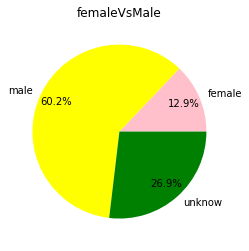

In [11]:
# 经检查，性别数据没有问题，有0，1，2三种性别，通过观察判断，0为女性，1为男性，2应该是未知
from matplotlib import pyplot as plt

colors  = ["pink","yellow","green"]  #设置颜色（循环显示）
labels = ['female','male','unknow']

plt.pie(x=quarter, colors=colors, labels=labels, autopct='%1.1f%%',pctdistance=0.8) 
plt.title('femaleVsMale')
plt.savefig("femaleVsMale.jpg")
plt.show()
plt.close()

可以看出，男性比例远多于女性与未知的比例。  
造成这一现象的原因，猜测有：  
1. 这是一位女性歌手，受众本身男性较多
2. 女性在社交平台上更愿意隐藏自己的性别，或者选择性别为男性
3. 数据来源为参与评论的用户，男性用户评论的积极性可能高于女性用户
4. 因为只取了1000个数据，所以有可能存在数据偏差
至于深究问题，例如是否女歌手男粉丝更多，是否存在女性隐藏自己性别的现象，为什么隐藏，如何识别等深入问题，不在此展示

### 3.2 粉丝年龄分布

In [12]:
dzq_fun_sample_df.dtypes

Unnamed: 0              int64
age                    object
createDays              int64
event_count             int64
fan_count               int64
follow_count            int64
gender                  int64
level                   int64
listening_songs_num     int64
location                int64
playlistCount           int64
userId                  int64
user_description       object
dtype: object

In [13]:
# 首先清理数据
age_data = dzq_fun_sample_df[ ~ dzq_fun_sample_df['age'].str.contains('unknow') ]
age_data['age'] = age_data['age'].astype('int')
valid_age_data = age_data[(age_data.age>3)&(age_data.age<90)]
valid_age_data.head()

/Users/yizhuoli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Unnamed: 0,age,createDays,event_count,fan_count,follow_count,gender,level,listening_songs_num,location,playlistCount,userId,user_description
5,5,19,825,1,2,3,1,7,1678,1,3,395964505,西南battle king
7,7,18,798,2,3,1,2,7,1391,3,2,413830444,NaN
8,8,18,678,1,2,1,2,9,10773,3,6,499332328,飞进你心里~
12,12,30,1,0,1,3,0,0,0,3,1,1821844233,才知你去了个地方叫永远，你可否代我发表退役宣言
18,18,19,568,0,6,3,1,8,6070,5,11,597738076,NaN


In [14]:
len(valid_age_data)

31

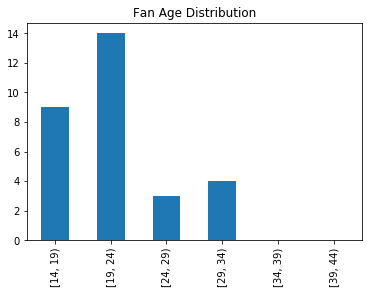

In [15]:
# 对年龄进行分组
age_range = list(range(int(valid_age_data['age'].min()), int(valid_age_data['age'].max()),5))
age_group = pd.cut(valid_age_data['age'].values, age_range, right=False)
# print(age_group.codes)#标签
# print(age_group.categories)#分组区间，长度8
frequency=age_group.value_counts()#series,区间-个数
# print(frequency.index)

frequency.plot(kind='bar')
plt.title('Fan Age Distribution')
plt.savefig("FanAgeDistribution.jpg")
plt.show()
plt.close()

从上图可知，我们所用的数据中，参与评论的邓紫棋的粉丝年龄，大都集中在14到24岁之间  
可能存在的原因为：
1. 歌手的歌曲本身吸引年轻人
2. 用户可能习惯将自己的网络年龄设置偏小
3. 年轻用户更愿意参与评论
4. 年轻的用户更愿意设置显示自己的年龄  

更可靠的结论需要通过更多的数据辅助分析

### 3.3 粉丝关注人数，被关注数分布

In [16]:
# 由前可知，关注与被关注都是int类型，只用查看是否有效即可。
dzq_fun_sample_df.columns

Index(['Unnamed: 0', 'age', 'createDays', 'event_count', 'fan_count',
       'follow_count', 'gender', 'level', 'listening_songs_num', 'location',
       'playlistCount', 'userId', 'user_description'],
      dtype='object')

In [17]:
valid_follow_count = dzq_fun_sample_df[dzq_fun_sample_df.follow_count>=0]
len(valid_follow_count)

93

In [18]:
valid_fan_count = dzq_fun_sample_df[dzq_fun_sample_df.fan_count>=0]
len(valid_fan_count)

93

In [19]:
valid_fan_count['fan_count'].max()

9

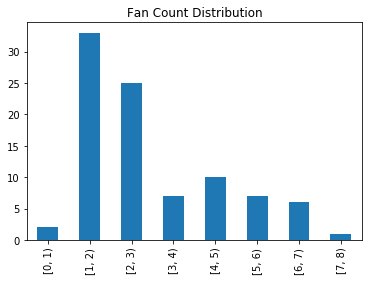

In [20]:
# 对粉丝数进行分组
fun_range = list(range(int(valid_fan_count['fan_count'].min()), int(valid_fan_count['fan_count'].max()),1))
fun_group = pd.cut(valid_fan_count['fan_count'].values, fun_range, right=False)
# print(fun_group.codes)#标签
# print(fun_group.categories)#分组区间，长度8
frequency=fun_group.value_counts()#series,区间-个数
# print(frequency.index)

frequency.plot(kind='bar')
plt.title('Fan Count Distribution')
plt.savefig("FanCountDistribution.jpg")
plt.show()
plt.close()

In [21]:
valid_fan_count['follow_count'].max()

9

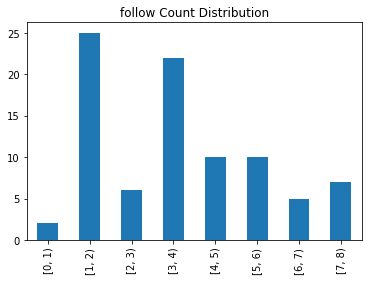

In [22]:
# 对follow人数进行分组
follow_range = list(range(int(valid_fan_count['follow_count'].min()), int(valid_fan_count['follow_count'].max()),1))
follow_group = pd.cut(valid_fan_count['follow_count'].values, follow_range, right=False)
# print(follow_group.codes)#标签
# print(follow_group.categories)#分组区间，长度8
frequency=follow_group.value_counts()#series,区间-个数
# print(frequency.index)

frequency.plot(kind='bar')
plt.title('follow Count Distribution')
plt.savefig("followCountDistribution.jpg")
plt.show()
plt.close()

从上面两张图可以看出，用户的整体粉丝数不高，也没有积极的去添加关注别人。与庞大的用户基数以及评论数形成一定的对比。  
最多的是一个，没记错的话，是网易云音乐小助手。
如果这一现象是普遍现象，那么可能的原因是：
1. 音乐天然带有私人的属性，个人喜好强烈，不容易形成传播
2. APP定位如此，没有在社交方面发力

建议很难讲，感觉需要根据应用的定位，分析是否真的要做社交，做怎样的社交。然后再进行更深入的分析。

### 3.4 粉丝听歌数量分布

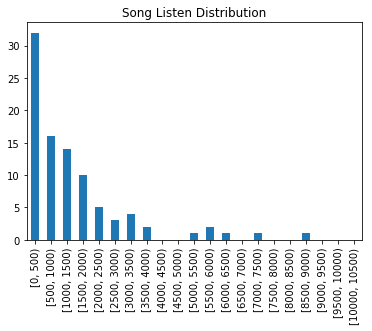

In [23]:
# 对听歌数量进行分组
song_range = list(range(int(valid_fan_count['listening_songs_num'].min()), int(valid_fan_count['listening_songs_num'].max()),500))
song_group = pd.cut(valid_fan_count['listening_songs_num'].values, song_range, right=False)
# print(song_group.codes)#标签
# print(song_group.categories)#分组区间，长度8
frequency=song_group.value_counts()#series,区间-个数
# print(frequency.index)

frequency.plot(kind='bar')
plt.title('Song Listen Distribution')
plt.savefig("SongListenDistribution.jpg")
plt.show()
plt.close()

由上图可知，用户听音乐的数量还是很可观的，大于500首的占65%以上。  
不知道用户粘性与听音乐数量是否有关，如果相关可以做一些有趣的用户留存尝试。  
用户粘性的衡量与用户周或者月活跃次数，听歌数量，评论次数等指标相关。现在就不做尝试了。

### 3.5 水军比例

从上面的非重复评论数与独立用户个数可知，存在大量用户重复评论行为。可以断定有不少的水军。  
因此，希望可以通过一定的模式，鉴别那些是水军的ID。

思路：  

水军可能存在的行为模式：
1. 在短时间内，进行多次评价。
2. 重复同一评价多次。

In [24]:
# 此处要使用没有经过去重的评论数据进行分析
# 先看一下有多少独立评论
import pandas as pd
dzq_comment_df = pd.read_csv('dzq_comment_sample.tsv',sep='\t',index_col='Unnamed: 0')
len(dzq_comment_df)

1330827

In [25]:
dzq_comment_df.head(5)

,content,likedCount,nickname,time,userId
0,如果我没有后顾之忧，父母都身体健康，我应该会跟你走的吧,0,鱈媛媛,1.555012e+12,4.208876e+08
1,不回家,0,还没有疯_,1.555011e+12,1.800399e+09
2,乎乎,0,还没有疯_,1.555011e+12,1.800399e+09
3,我没想到为了琳我能疯狂到,0,Chen_灿,1.555010e+12,5.682184e+08
4,第一遍，没感觉\n第二遍，嗯⊙∀⊙！\n第三遍，真香[流泪],0,玛丽到底苏不苏,1.555009e+12,3.186824e+08


In [26]:
# 看一下有多少非重复用户
unique_user = len([n for n in dzq_comment_df.duplicated('userId') if n is False])
unique_user

4388

In [27]:
# 看一下有多少非重复评论,考虑到不同用户相同评论，单独计算
len([n for n in dzq_comment_df.duplicated(['content','userId']) if n is False])

5434

In [28]:
# 看一下有多少非重复评论
len([n for n in dzq_comment_df.duplicated('content') if n is False])

5233

从这个独立用户与独立评论数可以看出，水军的比例还是很高的，这与之前数据去重时的结论一致  
然而如何判断账户是水军账户呢？根据开始的思路，可以有以下两个评判方法  
1. 同一账户，重复同一评论三次以上。
2. 一天内进行多次的评论，不管是否是重复。  

其实方法二与方法一有重复的部分，并且也存在真实用户一段时间内听歌大量评论的现象，但重复同一评论水军行为更严重。  

所以这里使用重复同一评论重复3次及以上的用户，即认为是水军用户。

In [29]:
items = list(dzq_comment_df['content'].map(str)+'  userId:'+dzq_comment_df['userId'].map(str))
len(items)

1330827

In [30]:
from collections import Counter

In [31]:
count = Counter(items)
count.most_common(21)

[('离开 是为了成全你   userId:nan', 1280675),
 ('0  userId:nan', 74),
 ('nan  userId:nan', 61),
 ('好听  userId:1750460948.0', 40),
 ('1  userId:nan', 27),
 ('粉丝何时才能上一百啊！我邓紫棋不要面子的嘛！🌚  userId:439224860.0', 27),
 ('删除拉黑是小孩子才做的事情，成年人只是不再讲话！  userId:1335258681.0', 20),
 ('爱  userId:509575221.0', 20),
 ('好听  userId:1666318719.0', 20),
 ('中国有14亿人口，网易云音乐有2亿用户，而你偏偏在这首歌的评论里面看到了我，然后你花了15秒钟来读我这一段话，你好 陌生人，。   愿你卡里有钱。车里有油。心里有爱。脚底有风。有空来绍兴找我喝酒 管醉。。  userId:1436184740.0',
  20),
 ('打卡  userId:1402781627.0', 20),
 ('收到  userId:104667283.0', 20),
 ('昂？  userId:116251718.0', 20),
 ('嘤嘤嘤  userId:470408433.0', 20),
 ('觉得gem自己作曲加编曲完整自己制作的不花哨而且很耐听，很有深意。  userId:1474088617.0', 20),
 ('1万评论走起  userId:1750460948.0', 20),
 ('既想纠缠你   又想放弃你   既想慢慢退出你的世界    但又怕真的失去了    又想跟你做到不联系   但又想跟你联系   爱而不得   弃而不舍   终是活该  userId:498738164.0',
  18),
 ('听了周杰伦十几年，一听就听出来2分04到2分12的节奏和旋律和周杰伦的红模仿1分50到1分58是一样的.多少歌手到现在都还在走周杰伦多少年前的老路。  userId:325285832.0',
  17),
 ('我今天分手了。我提出的，如果注定没有结果，那长痛不如短痛。真的好不舍，我喜欢的样子你都有啊。但我发现，你其实并不喜欢我，只是刚好遇见我。所以，这一段路就到这了。

In [32]:
string = '时间 空间 交融与相汇\n触碰间 最细微的尘埃\n也能见证此刻的美好\n光年之外的愿景遥不可及\n我只珍视你的一颦一笑\n喜欢你 一种简单的表达\n已足够满足  userId:39976833.0'
int(string.split('  userId:')[1].replace('.0',''))

39976833

In [33]:
count_dict = dict(Counter(items))
len(count_dict)

5434

In [34]:
count_dict.values()

dict_values([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 8, 7, 61, 27, 6, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 8, 7, 6, 5, 4, 3, 2, 27, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 74, 10, 10,

In [35]:
water_comment = list(filter(lambda x: count_dict[x] >= 3, count_dict))

In [36]:
water_user = []
for item in water_comment:
    userId = item.split('  userId:')[1]
    water_user.append(userId)
    
water_user = set(water_user)
len(water_user)

4222

因为有看到values里有很多10，所以用10来做评判标准更不容易判断错。

In [37]:
water_comment_10 = list(filter(lambda x: count_dict[x] >= 10, count_dict))

In [38]:
water_user_10 = []
for item in water_comment_10:
    userId = item.split('  userId:')[1]
    water_user_10.append(userId)
    
water_user_10 = set(water_user_10)
len(water_user_10)

3670

如果将用户水军可能性分为三个等级：  
重复评论数大于10的，为很有可能  
重复评论数大于3的，为有可能  
重复评论数小于3的，为不太有可能 

那么，从上面的分析可以看出：

In [39]:
print('总共'+str(unique_user)+'个独立用户中')
print('很可能水军的占： '+str(len(water_user_10)/unique_user*100)+'%')
print('可能是水军的占： '+str((len(water_user)-len(water_user_10))/unique_user*100)+'%')
print('不太可能是水军的占： '+str((unique_user-len(water_user))/unique_user*100)+'%')

总共4388个独立用户中
很可能水军的占： 83.63719234275297%
可能是水军的占： 12.579762989972654%
不太可能是水军的占： 3.7830446672743845%


从上面的结论可知，评论的用户中水军占比非常高，需要检查结论的可靠性，通过其他来源的数据做对比，检查结果的可靠性。  

如果上述结果成立，根据需求，分析存在大量水军的原因，例如为什么会有用户的userId为nan，为什么有1280675条评论都是一样的，是否有大量的广告等